In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
N_CLASSES = 2
N_FEATURES = 2
N_SAMPLES = 1000
np.random.seed(42)

os.makedirs('figs', exist_ok=True)
os.makedirs('data', exist_ok=True)

In [3]:
data_distr = np.random.random((N_CLASSES,N_FEATURES))
data_distr = data_distr / data_distr.sum(axis=(0,1))

data_sample_x = np.random.choice(N_FEATURES, size=N_SAMPLES, p=data_distr[0]/data_distr[0].sum())
data_sample_y = np.random.choice(N_CLASSES, size=N_SAMPLES, p=data_distr[1]/data_distr[1].sum())
data_sample = np.stack((data_sample_x, data_sample_y), axis=1)

data_sample_pd = pd.DataFrame(data_sample, columns=['X', 'Y'])
data_sample_pd.to_csv('data/data_sample.csv', index=False)

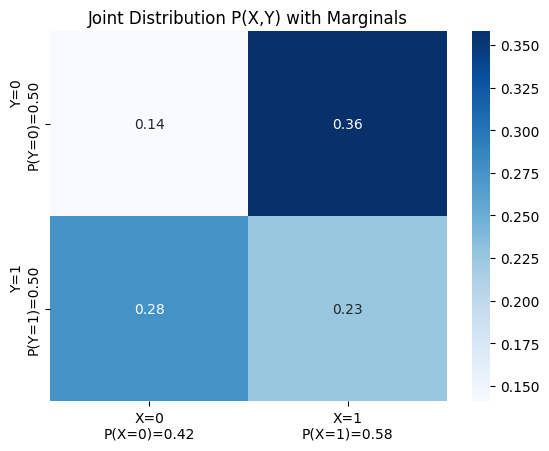

In [4]:
# Calculate marginal probabilities
p_x = data_distr.sum(axis=0)
p_y = data_distr.sum(axis=1)

# Create heatmap with marginal probabilities in labels
sns.heatmap(data_distr, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f'X=0\nP(X=0)={p_x[0]:.2f}', f'X=1\nP(X=1)={p_x[1]:.2f}'],
            yticklabels=[f'Y=0\nP(Y=0)={p_y[0]:.2f}', f'Y=1\nP(Y=1)={p_y[1]:.2f}'])
plt.title('Joint Distribution P(X,Y) with Marginals')
plt.savefig('figs/joint_table.png')
plt.show()

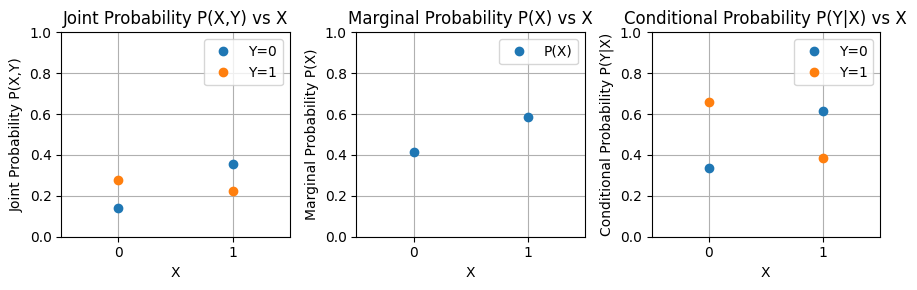

In [44]:
# Plot joint probabilities for each x value
def show(data_distr, ax, plot_type='joint'):
    x_values = np.arange(N_FEATURES)
    y_values = np.arange(N_CLASSES)

    if plot_type == 'joint':
        y_axis_label = 'Joint Probability P(X,Y)'
        for y in range(N_CLASSES):
            ax.plot(x_values, data_distr[y],'o', label=f'Y={y}', )
    elif plot_type == 'marginal':
        y_axis_label = 'Marginal Probability P(X)'
        ax.plot(x_values, data_distr.sum(axis=0) / data_distr.sum(axis=(0,1)),'o', label=f'P(X)')
    elif plot_type == 'conditional':
        y_axis_label = 'Conditional Probability P(Y|X)'
        for y in range(N_CLASSES):
            ax.plot(y_values, data_distr[y]/data_distr.sum(axis=0),'o', label=f'Y={y}', )

    ax.set_xlabel('X')
    ax.set_ylabel(y_axis_label)
    ax.set_title(f'{y_axis_label} vs X')
    ax.legend()
    ax.grid(True)
    ax.set_xticks([0,1])
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0, 1)

# Example usage with subplots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

show(data_distr, axes[0], plot_type='joint')
show(data_distr, axes[1], plot_type='marginal')
show(data_distr, axes[2], plot_type='conditional')

plt.tight_layout()
plt.savefig('figs/triple_plot.png')
plt.show()